In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
features = pd.read_csv('temps.csv')
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


In [8]:
print('数据维度：', features.shape)

数据维度： (348, 9)


In [13]:
#处理时间数据
import datetime
#分别得到 年，月，日
years = features['year']
months = features['month']
days = features['day']

#datetime 格式
dates = [str(int(year)) + '-' + str(int(month))+ '-' + str(int(day)) for year, month, day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

In [14]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

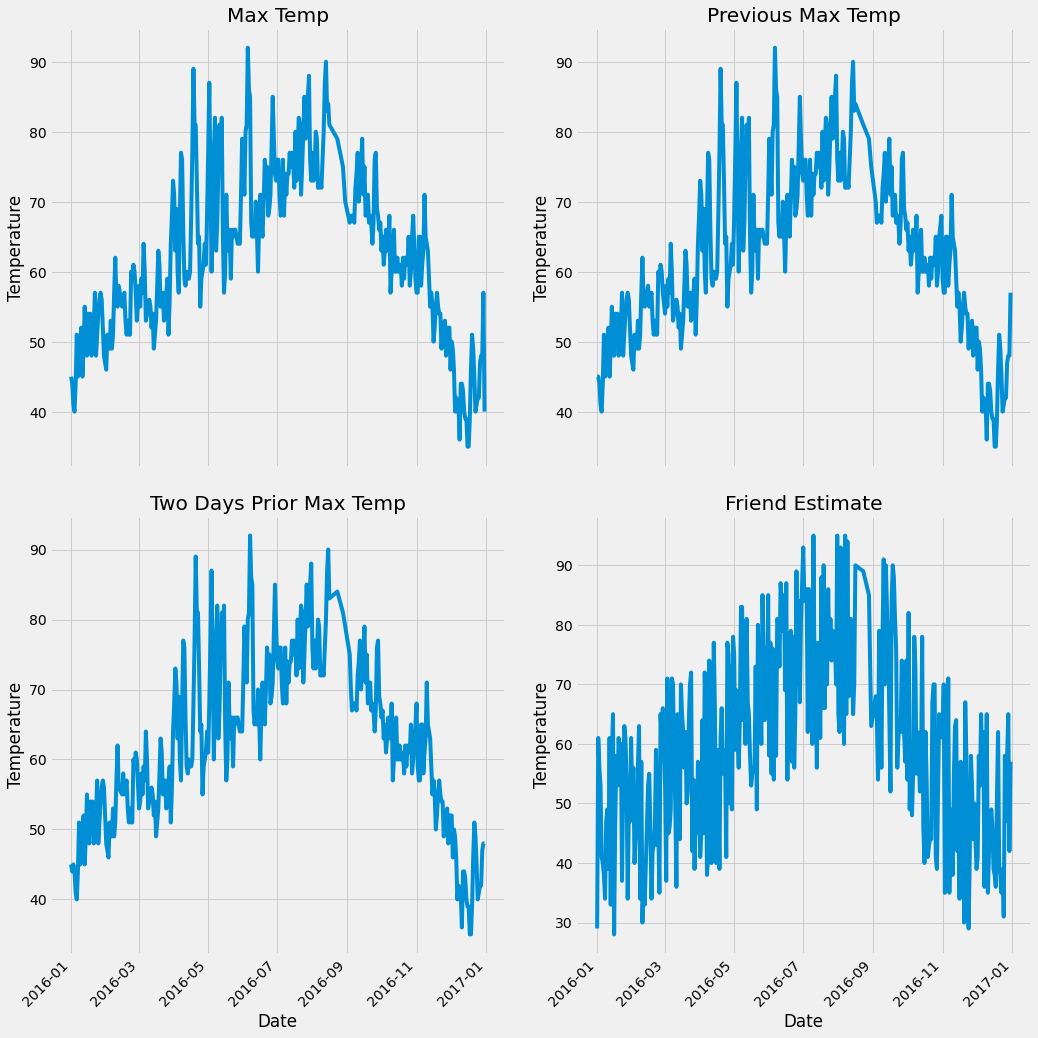

In [15]:
plt.style.use('fivethirtyeight')##准备画图,##指定默认风格
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,15))# 设置布局
 
fig.autofmt_xdate(rotation = 45)#X轴上旋转45度并且右对齐
 
 
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')# 
 
 
ax2.plot(dates, features['temp_1'])# 昨天
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')
 
 
ax3.plot(dates, features['temp_2'])# 前天
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')
 
 
ax4.plot(dates, features['friend'])# friend
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')#tight_layout会自动调整子图参数,使之填充整个图像区域
 
plt.tight_layout(pad=2)#会自动调整子图参数，使之填充整个图像区域。这是个实验特性，可能在一些情况下不工作。它仅仅检查坐标轴标签、刻度标签以及标题的部分。

In [16]:
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [17]:
# 标签
labels = np.array(features['actual'])
 
# 在特征中去掉标签
#drop函数默认删除行，列需要加axis = 1
features = features.drop('actual', axis = 1)
 
features

,year,month,day,temp_2,temp_1,average,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,41,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,42,42,45.2,47,0,0,0,0,0,1,0
344,2016,12,28,42,47,45.3,58,0,0,0,0,0,0,1
345,2016,12,29,47,48,45.3,65,0,0,0,0,1,0,0
346,2016,12,30,48,48,45.4,42,1,0,0,0,0,0,0


In [18]:
#对数据进行标准化,sklearn.preprocessing包提供了几个常用的实用函数和转换器类
from sklearn import preprocessing
#fit_transform是fit和transform的组合，既包括了训练又包含了转换。
input_features = preprocessing.StandardScaler().fit_transform(features)
#展示
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

数据标准化后损失值更小 模型收敛更快

# 构建网络模型 

input: [348,14] * [14,128] (第一层 128个神经元 14*128 + 128个参数) *[128*1] （第二层一个神经元 128 * 1 + 1 个参数）

In [19]:
#转化成张量格式
x = torch.tensor(input_features, dtype = float)
 
y = torch.tensor(labels, dtype = float)
 
#初始化权重参数
#返回一个张量，包含了从标准正态分布（均值为0，方差为1，即高斯白噪声）中抽取的一组随机数。
weights = torch.randn((14, 128), dtype = float, requires_grad = True)
biases = torch.randn(128, dtype = float, requires_grad = True)
weights2 = torch.randn((128, 1), dtype = float, requires_grad = True)
biases2 = torch.randn(1, dtype = float, requires_grad = True)
 
learning_rate = 0.001
losses = []
 
for i in range(1000):
    # 计算隐层;x.mm（weights） x与weights相乘
    hidden = x.mm(weights) + biases
    # 加入激活函数
    hidden = torch.relu(hidden)
    # 预测结果,第二层
    predictions = hidden.mm(weights2) + biases2
    # 计算损失
    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())
    
    # 打印损失值
    if i % 100 == 0:
        print('loss:', loss)
    # 反向传播
    loss.backward()
    
    #更新参数,-号表示反方向
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)
    
    # 每次迭代都得记得清空
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()
 
 

loss: tensor(3861.5510, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(156.3509, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(148.2761, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(145.2295, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.5370, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.5023, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.8033, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.3057, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.9320, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.6373, dtype=torch.float64, grad_fn=<MeanBackward0>)


# 更简单的网络模型

In [26]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
#通过Squential将网络层和激活函数结合起来，输出激活后的网络节点
my_nn = torch.nn.Sequential(
    #指定好输入输出
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(), 
    torch.nn.Linear(hidden_size, output_size),
)
#计算损失函数
cost = torch.nn.MSELoss(reduction='mean')
#优化器， 用做好的，会动态调整
optimizer = torch.optim.Adam(my_nn.parameters(), lr = 0.001)

In [27]:
#训练网络
losses = []
for i in range(1000):
    batch_loss = []
    #MINI-Batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        #取了部分数据
        xx = torch.tensor(input_features[start:end], dtype = torch.float, requires_grad = True)
        yy = torch.tensor(labels[start:end], dtype = torch.float, requires_grad = True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        #优化，梯度清零，反响传播,更新参数
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    # 打印损失
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 3973.0195
100 37.691444
200 35.642574
300 35.285152
400 35.114002
500 34.980526
600 34.8619
700 34.74451
800 34.62412
900 34.500477


# 训练结果

In [37]:
x = torch.tensor(input_features, dtype = torch.float)
predict = my_nn(x).data.numpy()
features

,year,month,day,temp_2,temp_1,average,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,41,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,42,42,45.2,47,0,0,0,0,0,1,0
344,2016,12,28,42,47,45.3,58,0,0,0,0,0,0,1
345,2016,12,29,47,48,45.3,65,0,0,0,0,1,0,0
346,2016,12,30,48,48,45.4,42,1,0,0,0,0,0,0


In [38]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
 
# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
 
# 同理，再创建一个来存日期和其对应的模型预测值
#months = features[:, feature_list.index('month')]
#days = features[:, feature_list.index('day')]
#years = features[:, feature_list.index('year')]

years = features['year']
months = features['month']
days = features['day']

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
 
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
 
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)})  

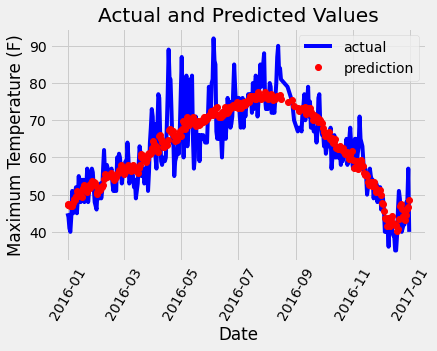

In [39]:
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
 
# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
 
# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');